### Download data directly from kaggle competition

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download imaterialist-fashion-2020-fgvc7

100% 19.2G/19.2G [03:17<00:00, 66.9MB/s]
100% 19.2G/19.2G [03:17<00:00, 104MB/s] 


In [ ]:
!unzip imaterialist-fashion-2020-fgvc7.zip

### Download from drive (I uploaded it to google drive for easier access)

In [1]:
from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1sy1ktZ46CC1s3PCpGQZUMK3W9V40Cbao'

download = drive.CreateFile({'id': file_id})
download.GetContentFile('module3_files.zip')

In [2]:
!unzip module3_files.zip -d /content/

Archive:  module3_files.zip
   creating: /content/module3_files/
  inflating: /content/module3_files/label_descriptions.json  
  inflating: /content/__MACOSX/module3_files/._label_descriptions.json  
  inflating: /content/module3_files/resized_train.zip  
  inflating: /content/__MACOSX/module3_files/._resized_train.zip  
  inflating: /content/module3_files/train.csv  
  inflating: /content/__MACOSX/module3_files/._train.csv  


In [3]:
!unzip module3_files/resized_train.zip -d resized_train

Streaming output truncated to the last 5000 lines.
  inflating: resized_train/5b2a185fa65d775c390b79054a2340c3.jpg  
  inflating: resized_train/b44d5b065ab507c1d4ceab39dcb19e1c.jpg  
  inflating: resized_train/94c4ba5803eea3ca05d4244b946a7454.jpg  
  inflating: resized_train/38cbe4e7a1d32fc04215f63b6763baa5.jpg  
  inflating: resized_train/1a649f250498cbc66ec491a5f75ba098.jpg  
  inflating: resized_train/651758bcfc95c3f00d7b50878e7b8d66.jpg  
  inflating: resized_train/a74b7db7bea0b072f470041afdc8d3ca.jpg  
  inflating: resized_train/88f474f59af0fcf86cfb75239e013cab.jpg  
  inflating: resized_train/75416e056a47167e2ec4ec4a64d25190.jpg  
  inflating: resized_train/947ef2545f63c24045748f9404132e47.jpg  
  inflating: resized_train/42eab34a1bf1f6b032451a849a975735.jpg  
  inflating: resized_train/e875b77cbdc919d6b03e95996f208178.jpg  
  inflating: resized_train/be649d8596f7460fbd21f00c53c750b1.jpg  
  inflating: resized_train/32cde452622a2e9e12001cd5af234d80.jpg  
  inflating: resized_trai

### Imports

In [4]:
import os
import json
import cv2
from tqdm import tqdm
import shutil
import random

from PIL import Image
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import sklearn.metrics

from google.colab.patches import cv2_imshow
%matplotlib inline

### General variables

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
torch.cuda.device_count()

1

In [7]:
train_labels = pd.read_csv('module3_files/train.csv')

In [8]:
train_labels.head(5)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


## Label description

In [9]:
with open('module3_files/label_descriptions.json', 'r') as file:
    label_desc_json = json.load(file)

In [10]:
categories_data = pd.DataFrame(label_desc_json['categories'])
attributes_data = pd.DataFrame(label_desc_json['attributes'])

In [11]:
categories_data.head(10)

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [12]:
attributes_data.head(10)

,id,name,supercategory,level
0,0,classic (t-shirt),nickname,1
1,1,polo (shirt),nickname,1
2,2,undershirt,nickname,1
3,3,henley (shirt),nickname,1
4,4,ringer (t-shirt),nickname,1
5,5,raglan (t-shirt),nickname,1
6,6,rugby (shirt),nickname,1
7,7,sailor (shirt),nickname,1
8,8,crop (top),nickname,1
9,9,halter (top),nickname,1


In [13]:
category_map, attribute_map = {}, {}

for _, row in categories_data.iterrows():
    category_map[row['id']] = row['name']

for _, row in attributes_data.iterrows():
    attribute_map[row['id']] = row['name']

In [14]:
train_labels['ClassIdCategory'] = train_labels['ClassId'].map(category_map)
train_labels['ClassIdCategory'] = train_labels['ClassIdCategory'].astype('category')

In [15]:
train_labels.head(5)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,ClassIdCategory
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",pants
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317","shirt, blouse"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163,collar
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204",sleeve
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219,pocket


In [16]:
category_distribution = (train_labels['ClassIdCategory'].value_counts()).to_frame()
category_distribution.reset_index(inplace=True)
category_distribution.columns=['category','count']
category_distribution.head(5)

,category,count
0,sleeve,59448
1,shoe,46374
2,neckline,34258
3,pocket,27179
4,dress,18739


# Data processing

In [17]:
train_directory = '/content/resized_train'
validation_directory = '/content/resized_validation'
os.makedirs(validation_directory, exist_ok=False)

num_files_to_move = int(0.2 * len(os.listdir(train_directory)))
files_to_move_for_validation = random.sample(os.listdir(train_directory), num_files_to_move)

for source_path in files_to_move_for_validation:
    shutil.move(os.path.join(train_directory, source_path), validation_directory)

In [18]:
train_directory = '/content/resized_train'

for file_name in os.listdir(train_directory):
  file_path = os.path.join(train_directory, file_name)
  if cv2.imread(file_path) is None:
    os.remove(file_path)
    print(f"Deleted file from resized_train: {file_name}")

print('---')

validation_directory = '/content/resized_validation'

for file_name in os.listdir(validation_directory):
    file_path = os.path.join(validation_directory, file_name)
    if cv2.imread(file_path) is None:
        os.remove(file_path)
        print(f"Deleted file from resized_validation: {file_name}")

---


## Prepare dataset

In [19]:
categories_ids = categories_data['id'].values.tolist()

In [20]:
def get_image(img_name, subset):
  return cv2.imread(f'{subset}/{img_name}')

In [21]:
def encode_label(img_name, subset):
  img_labels = train_labels[train_labels['ImageId'] == img_name.split('.')[0]]['ClassId'].values.tolist()

  # encodings = [0 for _ in range(len(categories_ids))]
  # for idx in range(len(encodings)):
  #   if idx in img_labels:
  #     encodings[idx] = 1

  encodings = torch.zeros(46)
  for idx_label in img_labels:
    encodings[int(idx_label)] = 1

  return encodings

In [22]:
class FashionDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.transform = transform

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, idx):
    image = get_image(self.image_fns[idx], self.image_dir.split('/')[-1])

    if image is None:
            raise ValueError(f"Error: Image not loaded - {self.image_fns[idx]}, subset - {self.image_dir.split('/')[-1]}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)

    if self.transform is not None:
      image = self.transform(image=image)['image']

    label = encode_label(self.image_fns[idx], self.image_dir.split('/')[-1])

    return image, label

In [23]:
train_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

valid_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

In [24]:
train_dataset = FashionDataset(image_dir='resized_train', transform=train_transform)
validation_dataset = FashionDataset(image_dir='resized_validation', transform=valid_transform)

# Model training


In [25]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.1 MB/s eta 0:00:00


In [26]:
import torchmetrics

def calculate_accuracy(output, target, device):
    accuracy_metrics = torchmetrics.classification.MultilabelF1Score(num_labels=46).to(device)
    accuracy = accuracy_metrics(output, target)
    return accuracy

In [27]:
class MetricMonitor:
    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"value": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["value"] += val
        metric["count"] += 1
        metric["avg"] = metric["value"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [28]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.to(params['device'])
    model.train()
    stream = tqdm(train_loader)

    all_losses = []
    all_steps = []

    for i, (images, labels) in enumerate(stream, start=1):
        images = images.to(params["device"], dtype=torch.float32)

        labels = labels.to(params["device"])

        output = model(images)
        loss = criterion(output, labels)
        accuracy = calculate_accuracy(output, labels, params["device"])

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

        all_losses.append(loss.item())
        all_steps.append(epoch * len(train_loader) + i)

    return (metric_monitor.metrics["Loss"]["avg"], metric_monitor.metrics["Accuracy"]["avg"], all_losses, all_steps)

In [29]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.to(params['device'])
    model.eval()
    stream = tqdm(val_loader)

    all_losses = []
    all_steps = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(stream, start=1):
            images = images.to(params["device"], dtype=torch.float32)
            labels = labels.to(params["device"])

            output = model(images)
            loss = criterion(output, labels)
            accuracy = calculate_accuracy(output, labels, params["device"])

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

            all_losses.append(loss.item())
            all_steps.append(epoch * len(val_loader) + i)

    return (metric_monitor.metrics["Loss"]["avg"], metric_monitor.metrics["Accuracy"]["avg"], all_losses, all_steps)

## ResNet18 (pretrained on ImageNet)

In [37]:
params_resnet50 = {
    "device": device,
    "lr": 0.0005,
    "num_workers": 2,
    "batch_size": 32,
    "epochs": 9,
}

In [38]:
train_loader = DataLoader(
    train_dataset, batch_size=params_resnet50["batch_size"], shuffle=True, pin_memory=True, num_workers=params_resnet50["num_workers"],
)
validation_loader = DataLoader(
    validation_dataset, batch_size=params_resnet50["batch_size"], shuffle=False, pin_memory=True, num_workers=params_resnet50["num_workers"],
)

In [39]:
weights = models.ResNet50_Weights.DEFAULT
model_resnet50 = models.resnet50(weights=weights)

In [40]:
criterion_resnet50 = nn.BCELoss()
optimizer_resnet50 = torch.optim.Adam(model_resnet50.parameters(), lr = params_resnet50['lr'])

In [41]:
# for param in model_resnet50.parameters():
#     param.requires_grad = False

In [42]:
model_resnet50.fc = nn.Sequential(
    nn.Linear(2048, len(categories_ids)),
    nn.Sigmoid()
)

In [43]:
train_metrics_lst = []
validation_metrics_lst = []

for epoch in range(1, params_resnet50["epochs"] + 1):
    train_metrics = train(train_loader, model_resnet50, criterion_resnet50, optimizer_resnet50, epoch, params_resnet50)
    validation_metrics = validate(validation_loader, model_resnet50, criterion_resnet50, epoch, params_resnet50)

    train_metrics_lst.append(train_metrics)
    validation_metrics_lst.append(validation_metrics)

Epoch: 1. Train.      Loss: 0.1997 | Accuracy: 0.1915: 100%|██████████| 1141/1141 [17:31<00:00,  1.09it/s]
Epoch: 1. Validation. Loss: 0.1717 | Accuracy: 0.2354: 100%|██████████| 286/286 [04:19<00:00,  1.10it/s]
Epoch: 2. Train.      Loss: 0.1614 | Accuracy: 0.2636: 100%|██████████| 1141/1141 [17:47<00:00,  1.07it/s]
Epoch: 2. Validation. Loss: 0.1590 | Accuracy: 0.2582: 100%|██████████| 286/286 [04:19<00:00,  1.10it/s]
Epoch: 3. Train.      Loss: 0.1428 | Accuracy: 0.3082: 100%|██████████| 1141/1141 [17:39<00:00,  1.08it/s]
Epoch: 3. Validation. Loss: 0.1541 | Accuracy: 0.2797: 100%|██████████| 286/286 [04:14<00:00,  1.12it/s]
Epoch: 4. Train.      Loss: 0.1254 | Accuracy: 0.3489: 100%|██████████| 1141/1141 [17:40<00:00,  1.08it/s]
Epoch: 4. Validation. Loss: 0.1540 | Accuracy: 0.2997: 100%|██████████| 286/286 [04:18<00:00,  1.10it/s]
Epoch: 5. Train.      Loss: 0.1076 | Accuracy: 0.3911: 100%|██████████| 1141/1141 [17:47<00:00,  1.07it/s]
Epoch: 5. Validation. Loss: 0.1596 | Accuracy

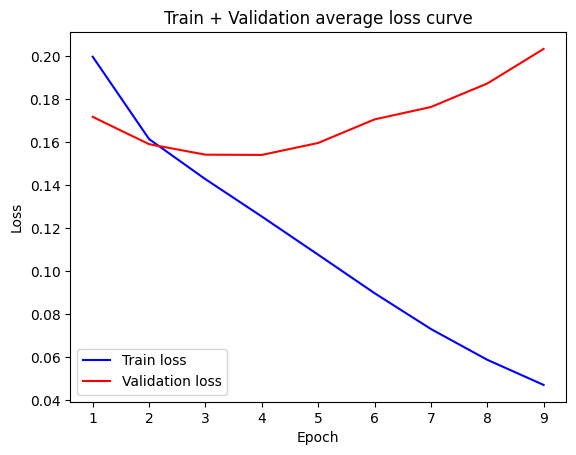

In [44]:
plt.plot(np.arange(1, params_resnet50['epochs'] + 1, 1), [metric[0] for metric in train_metrics_lst], color='b', label='Train loss')
plt.plot(np.arange(1, params_resnet50['epochs'] + 1, 1), [metric[0] for metric in validation_metrics_lst], color='r', label='Validation loss')

plt.title('Train + Validation average loss curve')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

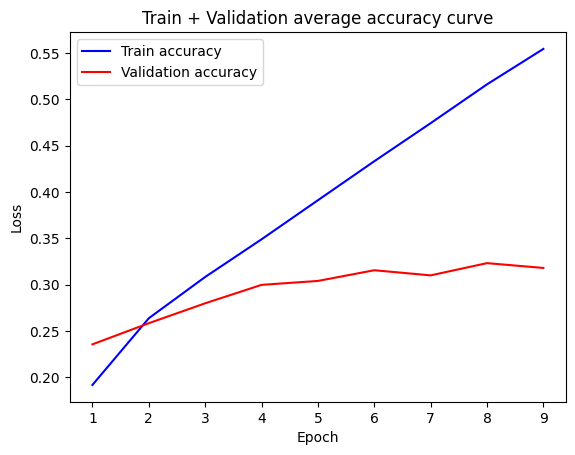

In [46]:
plt.plot(np.arange(1, params_resnet50['epochs'] + 1, 1), [metric[1].cpu() for metric in train_metrics_lst], color='b', label='Train accuracy')
plt.plot(np.arange(1, params_resnet50['epochs'] + 1, 1), [metric[1].cpu() for metric in validation_metrics_lst], color='r', label='Validation accuracy')

plt.title('Train + Validation average accuracy curve')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [47]:
torch.save(model_resnet50.state_dict(), 'model_resnet50_pretrained.pth')